In [1]:
import matplotlib
import seaborn
import pandas
import gzip
import igraph
import itertools
import re
import os
import math
import numpy as np
import scipy.stats

from collections import Counter, OrderedDict

%matplotlib inline

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [2]:
ecosystems = ['npm', 'cran', 'rubygems']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (10, 3)
SHOW_TITLE = True

def savefig(fig, name):
    return fig.savefig('figures/{}.pdf'.format(name), bbox_inches='tight')

## Read graphs

In [3]:
GRAPH_DIR = '../data/graphs'

def read_graph(filename):
    g = igraph.read(os.path.join(GRAPH_DIR, filename), format='graphmlz')
    date = re.search(r'(\d\d\d\d-\d\d-\d\d)', filename).group(1)
    return date, g
    
def read_graphs(e):
    files = os.listdir(GRAPH_DIR)
    files.sort()
    return [read_graph(f) for f in files
            if re.search(r'^{}.*\.graphml\.gz'.format(e), f)]

graphs = OrderedDict((e, OrderedDict(read_graphs(e))) for e in ecosystems)

## Compute metrics

In [4]:
def minimum_dependent(transitive_indegree, ratio):
    return sum(1 for x in transitive_indegree if x - 1 >= ratio)

def graph_metrics(g, d, e):
    package_size = np.array(list(filter(lambda x: not math.isnan(x), g.vs['size'])))
    transitive_indegree = g.neighborhood_size(order=len(g.vs), mode='in')
    return {'time': d, 'ecos': e, 'size': len(g.vs),
            'biggest_wcc': len(g.components(igraph.WEAK).giant().vs) if len(g.vs) else 0,
            'with_deps': len([x for x in g.outdegree() if x > 0]),
            'with_revdeps': len([x for x in g.indegree() if x > 0]),
            'isolated': len([x for x in g.degree() if x == 0]),
            'median_size': np.median(package_size),
            'mean_size': np.mean(package_size),
            'max_indegree': max(g.indegree()),
            'max_dependent': max(transitive_indegree) - 1,
            'dependent1': minimum_dependent(transitive_indegree, 0.01 * len(g.vs)),
            'dependent5': minimum_dependent(transitive_indegree, 0.05 * len(g.vs)),
            'dependent10': minimum_dependent(transitive_indegree, 0.1 * len(g.vs))}

def ecos_metrics(e, x):
    metrics = pandas.DataFrame([graph_metrics(g, d, e) for d, g in x.items() if len(g.vs)])
    metrics['time'] = pandas.to_datetime(metrics.time)
    return metrics.set_index(['time']).sort_index()

ecos_metrics = OrderedDict((e, ecos_metrics(e, x)) for e, x in graphs.items())

In [5]:
dates = pandas.date_range('2012-04-01', '2016-04-01', freq='AS-APR')

def package_metrics(e, g):
    data = [pandas.DataFrame({'date': d, 'ecos': e, 'package': g.vs['name'], 'size': g.vs['size'],
                              'indegree': g.indegree(), 'outdegree': g.outdegree(),
                              'transitive_in': [x -1 for x in g.neighborhood_size(order=len(g.vs), mode='in')],
                              'transitive_out': [x - 1 for x in g.neighborhood_size(order=len(g.vs), mode='out')]})
            for d, g in g.items() if d in dates]
    return (pandas.concat(data)
            .assign(isolated=lambda d: d.indegree + d.outdegree == 0)
            .sort_values('date'))

package_metrics = {e: package_metrics(e, g) for e, g in graphs.items()}

## Package evolution

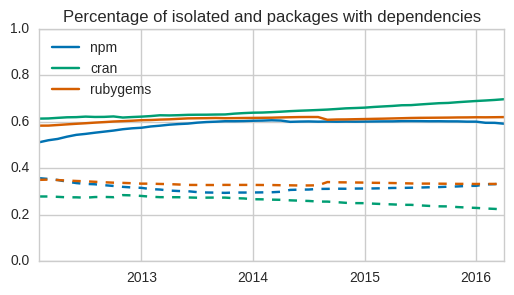

In [6]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Percentage of isolated and packages with dependencies')
for e, m in ecos_metrics.items():
    data = (m.query('size > 1 and time > "2012"')
             .assign(with_deps=lambda d: d.with_deps / d['size'])
             .assign(isolated=lambda d: d.isolated / d['size']))
    data.with_deps.plot(ax=ax, style='-', color=COLORS[e], label=e, legend=True)
    data.isolated.plot(ax=ax, style='--', color=COLORS[e])

ax.set_xlabel('')
ax.set_ylim(0,1)
savefig(fig, 'evol_deps_isolated')

## Degree distributions

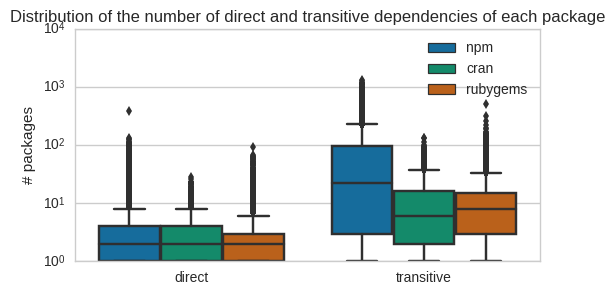

In [7]:
data = pandas.concat([data[data.date == max(data.date)]
                      for data in package_metrics.values()], ignore_index=True)
data = pandas.melt(data.rename(columns={'transitive_in': 'dependent packages',
                                        'transitive_out': 'transitive',
                                        'outdegree': 'direct'}),
                   id_vars=['date', 'ecos', 'package'])

fig, ax = matplotlib.pyplot.subplots()
if SHOW_TITLE:
    ax.set_title('Distribution of the number of direct and transitive dependencies of each package')
seaborn.boxplot(data=data.query('value > 0 and variable in ("transitive", "direct")'),
                x='variable', y='value', hue='ecos', ax=ax, hue_order=ecosystems)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('# packages')
ax.legend(title='')
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'boxplot_outdegree')

In [8]:
for e in ecosystems:
    print(e)
    data = package_metrics[e].query('date == "2016-04-01" and outdegree > 0')
    print('# packages with deps: {}'.format(data.outdegree.count()))
    print('75% direct: '.format(data.outdegree.quantile(0.75)))
    print('75% transitive: {}'.format(data.transitive_out.quantile(0.75)))
    print('median transitive: {}'.format(data.transitive_out.median()))
    print('mean transitive: {}'.format((data.transitive_out / data.outdegree).mean()))
    print()

npm
# packages with deps: 163658
75% direct: 
75% transitive: 95.0
median transitive: 22.0
mean transitive: 22.139612175176534

cran
# packages with deps: 6574
75% direct: 
75% transitive: 16.0
median transitive: 6.0
mean transitive: 3.7906909356325995

rubygems
# packages with deps: 72094
75% direct: 
75% transitive: 15.0
median transitive: 8.0
mean transitive: 6.349457698811685



In [9]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    
    effect sizes as "small, d = .2," "medium, d = .5," and "large, d = .8"
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / pandas.np.sqrt(pooled_var)
    return d

def cliffsDelta(lst1,lst2):
    """
    0.147 / 0.33 / 0.474 (small/medium/large) 
    """
    def runs(lst):
        "Iterator, chunks repeated values"
        for j,two in enumerate(lst):
            if j == 0:
                one,i = two,0
            if one!=two:
                yield j - i,one
                i = j
            one=two
        yield j - i + 1,two
        
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats,x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] <  x: 
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x: 
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n) 
    return abs(d)

In [10]:
data = pandas.concat([data[data.date == max(data.date)]
                      for data in package_metrics.values()], ignore_index=True)

for kind in ['indegree', 'outdegree', 'transitive_in', 'transitive_out']:
    print(kind)
    for ecos1, ecos2 in itertools.permutations(ecosystems, 2):
        temp1 = data.query('ecos == "{}" and {} > 0'.format(ecos1, kind))[kind]
        temp2 = data.query('ecos == "{}" and {} > 0'.format(ecos2, kind))[kind]
    
        score, p_value = scipy.stats.mannwhitneyu(temp1, temp2, alternative='less')
        print('Mann-Whitney-u for {}<{} : {:f} (p-value: {:f})'.format(ecos1, ecos2, score, p_value))
        print('Cohen\'s d: {:f}'.format(CohenEffectSize(temp1, temp2)))
        print('Cliff\'s delta: {:f}'.format(cliffsDelta(temp1, temp2)))
        # score, p_value = scipy.stats.kruskal(temp1, temp2)
        # print('Kruskal-Wallis H-test for {}!={} : {:f} (p-value: {:f})'.format(ecos1, ecos2, score, p_value))
        
    print()

indegree
Mann-Whitney-u for npm<cran : 56153511.500000 (p-value: 0.000000)
Cohen's d: 0.004389
Cliff's delta: 0.119380
Mann-Whitney-u for npm<rubygems : 468188233.500000 (p-value: 0.996195)
Cohen's d: -0.002868
Cliff's delta: 0.012714
Mann-Whitney-u for cran<npm : 71378288.500000 (p-value: 1.000000)
Cohen's d: -0.004389
Cliff's delta: 0.119380
Mann-Whitney-u for cran<rubygems : 18888248.500000 (p-value: 1.000000)
Cohen's d: -0.010304
Cliff's delta: 0.130349
Mann-Whitney-u for rubygems<npm : 456432166.500000 (p-value: 0.003805)
Cohen's d: 0.002868
Cliff's delta: 0.012714
Mann-Whitney-u for rubygems<cran : 14531953.500000 (p-value: 0.000000)
Cohen's d: 0.010304
Cliff's delta: 0.130349

outdegree
Mann-Whitney-u for npm<cran : 548714946.000000 (p-value: 0.997568)
Cohen's d: 0.127329
Cliff's delta: 0.020023
Mann-Whitney-u for npm<rubygems : 7272877546.500000 (p-value: 1.000000)
Cohen's d: 0.337052
Cliff's delta: 0.232821
Mann-Whitney-u for cran<npm : 527172746.000000 (p-value: 0.002432)
Coh

## Ecosystem vulnerability

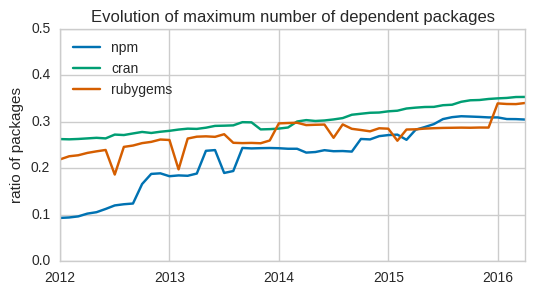

In [11]:
dates = pandas.date_range('2012-01-01', '2016-04-01', freq='MS')
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Evolution of maximum number of dependent packages')
for e, m in ecos_metrics.items():
    data = m.loc[dates].assign(max_dependent=lambda d: d.max_dependent / d['size'])
    data.max_dependent.plot(ax=ax, style='-', color=COLORS[e], label=e, legend=True)

ax.set_ylim(0, 0.5)
ax.set_xlabel('')
ax.set_ylabel('ratio of packages')
savefig(fig, 'evol_max_dependent')

In [12]:
for e in ecosystems:
    print(e)
    print(ecos_metrics[e].query('time == "2016-04-01"')['max_dependent'])
    print(ecos_metrics[e].query('time == "2016-04-01"')['max_dependent'] /
          ecos_metrics[e].query('time == "2016-04-01"')['size'])
    print()

npm
time
2016-04-01    84324
Name: max_dependent, dtype: int64
time
2016-04-01    0.30482
dtype: float64

cran
time
2016-04-01    3333
Name: max_dependent, dtype: int64
time
2016-04-01    0.353409
dtype: float64

rubygems
time
2016-04-01    39570
Name: max_dependent, dtype: int64
time
2016-04-01    0.340375
dtype: float64



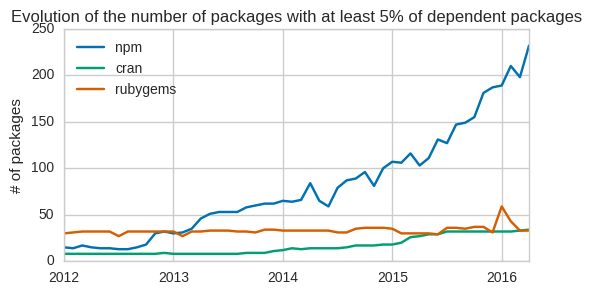

In [13]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Evolution of the number of packages with at least 5% of dependent packages')
for e, m in ecos_metrics.items():
    data = m.loc[dates].assign(max_dependent=lambda d: d.dependent5)
    data.max_dependent.plot(ax=ax, style='-', color=COLORS[e], label=e, legend=True)

ax.set_xlabel('')
ax.set_ylabel('# of packages')
savefig(fig, 'evol_5perc_breakers')